<a href="https://colab.research.google.com/github/wiroel/my-repo/blob/main/Discretization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Numerical to categorical values
sometimes dataset looks better if it is displayed in categorical values,
eg-dataset of playstore (values=32, 10836284585, 994475), very disticnt and the graph wont look good
so if,,,, binning is done (eg- 10, 100, 1000, 10k..... 1M ..... 1B), then it becomes easier to represent graphically and in further coding


types:
-Binning (Discretization)
-Binarization (Quantile Binning)

# Discretization (Binning)
- transforms continuous ariables into discrete by creating a set of contiguous intervals that spans the range of variables' values

- to handle outliers
- to improve value spread

Types:
- Unsupervised(equal-width/uniform,   equal-frequency/Quantile-binning,    k-means)
- Supervised(decision tree binning)
- custom binning

# Equal Width (Uniform Binning)
eg- (0-10), (10-20), (20-30)....(90-100)

- bins number is given by us

- interval formula:  (max-min)/total bins

use: handles outliers, no change of spread

# Equal Frequency (Quantile Binning)
- eg: (0-16) has 10% of total number N
    (16-20) has 20% of N(more like (0-20) has 20% population)
    (20-22) has 30% of N

- so its more like every discrete contiguous range has equal number of frequencies

# K-Means
- forms clusters even in N-Dimension
- interval = centroid

sklearn.preprocessing ma KBinsDiscretization has 3 parameters
- n-bins
- strategy : ('uniform','quantile(default)','kmeans')
- encode : (ordinal, onehot onehot-dense)

In [49]:
!pip install matplotlib

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer

In [4]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/titanic.csv'

df = pd.read_csv(file_path, usecols=['Age', 'Fare', 'Survived'])

df.head(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [5]:
df.dropna(inplace=True)   # just to make dataset more varied for discretization

In [6]:
df.shape


(714, 3)

In [7]:
X = df.iloc[:, 1:3]
y = df.iloc[:, 0]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
X_train.head(5)

,Age,Fare
328,31.0,20.5250
73,26.0,14.4542
253,30.0,16.1000
719,33.0,7.7750
666,25.0,13.0000


In [9]:
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.6293706293706294

In [15]:
clf = DecisionTreeClassifier()

np.mean(cross_val_score(clf, X, y, scoring="accuracy", cv=5))

np.float64(0.6190584063823501)

In [16]:
kbin_age = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
kbin_fare = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

In [76]:
trf = ColumnTransformer([
    ('First', kbin_age, [0]),
    ('Second', kbin_fare, [1])
], remainder='passthrough')

In [19]:
X_train_transformed = trf.fit_transform(X_train)
X_test_transformed = trf.fit_transform(X_test)

In [22]:
trf.named_transformers_['First']

KBinsDiscretizer(encode='ordinal', n_bins=10)

In [23]:
trf.named_transformers_['Second'].bin_edges_

array([array([  0.     ,   7.74336,   7.925  ,   8.6625 ,  10.5    ,  14.4542 ,
               22.62   ,  28.39   ,  38.1    ,  57.78336, 512.3292 ])          ],
      dtype=object)

In [24]:
trf.named_transformers_['First'].n_bins_

array([10])

In [27]:
X_train_transformed

array([[5., 5.],
       [4., 4.],
       [5., 5.],
       ...,
       [7., 9.],
       [6., 5.],
       [6., 2.]])

In [30]:
output = pd.DataFrame({
    'age': X_train['Age'],
    'age_trf': X_train_transformed[:, 0],
    'fare': X_train['Fare'],
    'fare_trf': X_train_transformed[:, 1]
})

output.head(5)

,age,age_trf,fare,fare_trf
328,31.0,5.0,20.5250,5.0
73,26.0,4.0,14.4542,4.0
253,30.0,5.0,16.1000,5.0
719,33.0,6.0,7.7750,1.0
666,25.0,4.0,13.0000,4.0


In [33]:
output['age_labels']= pd.cut(x=X_train['Age'], bins=trf.named_transformers_['First'].bin_edges_[0].tolist())
output['fare_labels'] = pd.cut(x=X_train['Fare'], bins=trf.named_transformers_['Second'].bin_edges_[0].tolist())

In [35]:
output.sample(5)

,age,age_trf,fare,fare_trf,age_labels,fare_labels
419,10.0,0.0,24.1500,5.0,"(1.0, 11.0]","(22.62, 28.39]"
677,18.0,1.0,9.8417,3.0,"(17.0, 20.6]","(8.662, 10.5]"
248,37.0,7.0,52.5542,8.0,"(34.4, 38.6]","(38.1, 57.783]"
122,32.5,6.0,30.0708,7.0,"(30.1, 34.4]","(28.39, 38.1]"
785,25.0,4.0,7.2500,0.0,"(24.0, 28.0]","(0.0, 7.743]"


In [37]:
clf = DecisionTreeClassifier()
clf.fit(X_train_transformed, y_train)
y_pred2=clf.predict(X_test_transformed)
accuracy_score(y_test, y_pred2)

0.6853146853146853

In [38]:
X_trf = trf.fit_transform(X)
np.mean(cross_val_score(DecisionTreeClassifier(), X_trf, y, scoring='accuracy', cv=5))

np.float64(0.6624642962671131)

In [52]:
def discretize(bins, strategy):
  kbin_age= KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy=strategy)
  kbin_fare= KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy=strategy)

  trf2 = ColumnTransformer([
      ('first', kbin_age, [0]),
      ('second', kbin_fare, [1])
  ])

  X_trf2=trf2.fit_transform(X)
  print(np.mean(cross_val_score(DecisionTreeClassifier(), X_trf2, y, scoring='accuracy', cv=5)))

  plt.figure(figsize=(14,4))
  plt.subplot(121)
  plt.hist(X['Age'])
  plt.title('Age Before')

  plt.subplot(122)
  plt.hist(X_trf2[:, 0], color='red')
  plt.title('Age after')

  plt.show()

  plt.figure(figsize=(14,4))
  plt.subplot(121)
  plt.hist(X['Fare'])
  plt.title("Fare Before")

  plt.subplot(122)
  plt.hist(X_trf2[:, 1], color='red')
  plt.title('Fare After')

  plt.show()

0.6639121441938343


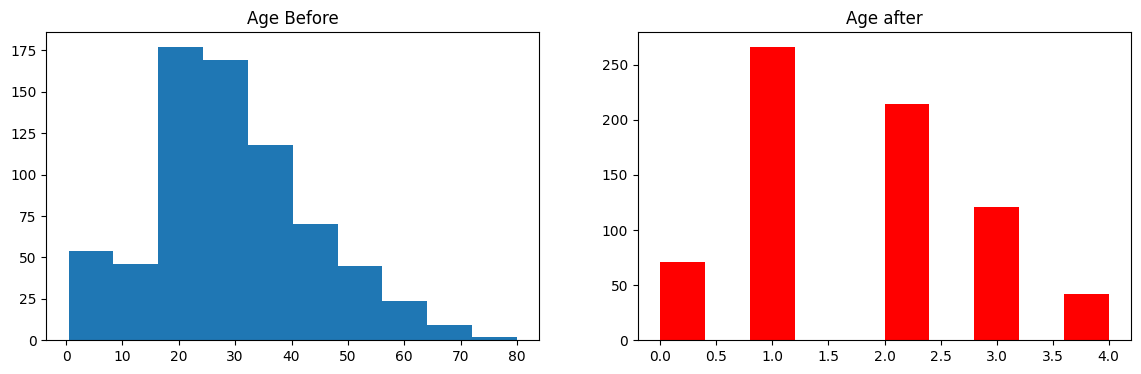

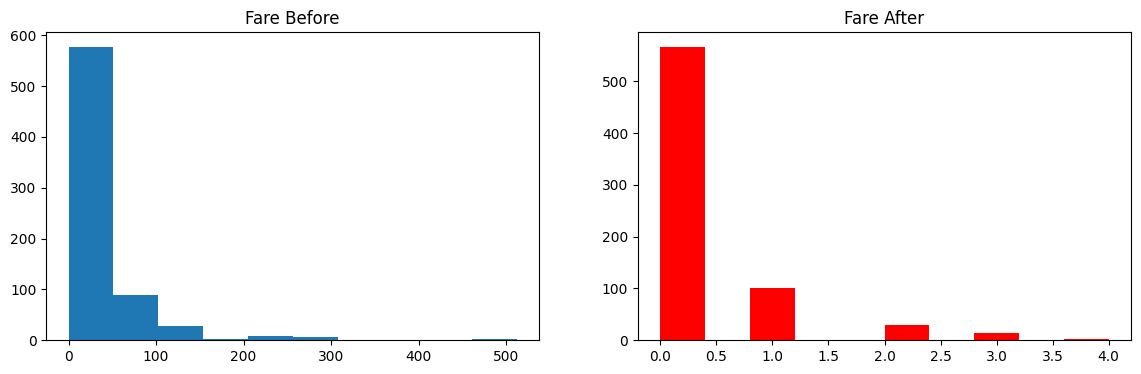

In [55]:
discretize(5, 'kmeans')

# Custom Binning
- eg- (0-18)=kids
      (18-50)= adults
      (50-100)= elderly

- but it is not available in scikit learn so we have to write different logic from pandas

## Binarization

- you convert continuous variable into binary variable
- eg- for image 0-255 colors and to turn it into black ans white you make {(127>)=0} and {(127<)=1}
- has a class called Binerizer in preprocessing and has 2 parameters(threshold and copy=True)

In [56]:
file_path = '/content/drive/MyDrive/titanic.csv'

df = pd.read_csv(file_path, usecols=['Age', 'Fare', 'Parch', 'SibSp', 'Survived'])
df.head()

,Survived,Age,SibSp,Parch,Fare
0,0,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,1,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,0,35.0,0,0,8.0500


In [57]:
df.dropna(inplace=True)

In [58]:
df['Family']= df['SibSp']+df['Parch']

what i am trying to do is to see if the given insaan was alone when travelling or not, so if family has 0 then he did travel alone, if family=1, he was not alone

In [70]:
df.head(5)

,Survived,Age,Fare,Family
0,0,22.0,7.2500,1
1,1,38.0,71.2833,1
2,1,26.0,7.9250,0
3,1,35.0,53.1000,1
4,0,35.0,8.0500,0


In [63]:
X = df.iloc[:, 1:4]
y=df.iloc[:, 0]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
X_train.head()

,Age,Fare,Family
328,31.0,20.5250,2
73,26.0,14.4542,1
253,30.0,16.1000,1
719,33.0,7.7750,0
666,25.0,13.0000,0


In [66]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.6293706293706294

In [67]:
np.mean(cross_val_score(DecisionTreeClassifier(), X, y, scoring='accuracy', cv=5))

np.float64(0.6596473948586624)

In [71]:
from sklearn.preprocessing import Binarizer

In [78]:
trf3= ColumnTransformer([
    ('bin', Binarizer(threshold=0, copy=False), [2])
], remainder='passthrough')

In [81]:
X_train_trans = trf3.fit_transform(X_train)
X_test_trans = trf3.fit_transform(X_test)

pd.DataFrame(X_train_trans, columns=['family', 'age', 'fare'])

,family,age,fare
0,1.0,31.0,20.5250
1,1.0,26.0,14.4542
2,1.0,30.0,16.1000
3,0.0,33.0,7.7750
4,0.0,25.0,13.0000
...,...,...,...
566,1.0,46.0,61.1750
567,0.0,25.0,13.0000
568,0.0,41.0,134.5000
569,1.0,33.0,20.5250


In [84]:
clf = DecisionTreeClassifier()
clf.fit(X_train_trans, y_train)
y_pred = clf.predict(X_test_trans)
accuracy_score(y_test, y_pred)

0.6013986013986014

In [85]:
X_trf = trf3.fit_transform(X)
np.mean(cross_val_score(DecisionTreeClassifier(), X_trf, y, scoring='accuracy', cv=5))

np.float64(0.6162612035851472)